In [15]:
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm
import pathlib
from google.cloud import storage
import tensorflow_hub as hub
from io import BytesIO
from tensorflow.python.lib.io import file_io
import seaborn as sn
from sklearn.metrics import confusion_matrix

In [16]:
train_data = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/train_data_augment2x_siebren.csv", header=None)
val_data = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/val_data_augment_siebren.csv", header=None)
test_data = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/test_data_augment_siebren.csv", header=None)
CLASS_NAMES = train_data[0].unique()

In [17]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

BATCH_SIZE = 128
# 10 is a magic number tuned for local training of this dataset.
SHUFFLE_BUFFER = 10 * BATCH_SIZE
AUTOTUNE = tf.data.experimental.AUTOTUNE

VALIDATION_IMAGES = 370
VALIDATION_STEPS = VALIDATION_IMAGES // BATCH_SIZE

In [18]:
def decode_img(img, reshape_dims):
    # Convert the compressed string to a 3D uint8 tensor.
    img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Resize the image to the desired size.
    return tf.image.resize(img, reshape_dims)

In [19]:
MAX_DELTA = 63.0 / 255.0  # Change brightness by at most 17.7%
CONTRAST_LOWER = 0.2
CONTRAST_UPPER = 1.8
img_list = []

def read_and_preprocess(image_bytes, label, augment):
    if augment == "True":
        img = decode_img(image_bytes, [IMG_WIDTH, IMG_HEIGHT])
        img = tf.image.flip_left_right(img)
#         img = decode_img(image_bytes, [IMG_HEIGHT + 10, IMG_WIDTH + 10])
#         img = tf.image.random_crop(img, [IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
#         img = tf.image.random_flip_left_right(img)
#         img = tf.image.random_brightness(img, MAX_DELTA)
#         img = tf.image.random_contrast(img, CONTRAST_LOWER, CONTRAST_UPPER)
    else:
        img = decode_img(image_bytes, [IMG_WIDTH, IMG_HEIGHT])
    return img, label


In [20]:
def decode_csv(csv_row):
    record_defaults = ["img", "path", "augment"]
    
    label_string, filename, augment = tf.io.decode_csv(csv_row, record_defaults)
    image_bytes = tf.io.read_file(filename=filename)
    label = tf.math.equal(CLASS_NAMES, label_string)

    return image_bytes, label, augment

In [21]:
def load_dataset(csv_of_filenames, batch_size, training=True):    
    dataset = tf.data.TextLineDataset(filenames=csv_of_filenames) \
        .map(decode_csv, num_parallel_calls=tf.data.AUTOTUNE)
    
    dataset = dataset \
        .map(read_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
        .repeat(count=1)  # Each photo used once.
    
    # Prefetch prepares the next set of batches while current batch is in use.
    return dataset.batch(batch_size=batch_size).prefetch(buffer_size=AUTOTUNE)
#     return dataset.range(4).interleave(lambda _: dataset.batch(batch_size=batch_size), num_parallel_calls=tf.data.AUTOTUNE )

# Model

In [22]:
# data
train_path = "gs://dataset-gabon/train_val_test_csv_Siebren/train_data_augment2x_siebren.csv"
eval_path = "gs://dataset-gabon/train_val_test_csv_Siebren/val_data_augment_siebren.csv"
nclasses = len(CLASS_NAMES)

In [23]:
base_model = keras.applications.MobileNetV2(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

In [24]:
base_model.trainable = False

In [25]:
inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(rate=0.5)(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(nclasses, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [26]:
# model.load_weights("gs://dataset-gabon/train_val_test_csv_Siebren/CNN_models/MobileNetV2_augmented2x/saved_weights/cp.ckpt")
# model = keras.models.load_model("gs://dataset-gabon/train_val_test_csv_Siebren/CNN_models/Xception_augmented2x_finetuned/model.H5")

In [27]:
model.layers[1].trainable = False

In [28]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 28)                35868     
Total params: 2,293,852
Trainable params: 35,868
Non-trainable params: 2,257,984
_________________________________________________________________


In [29]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

train_ds = load_dataset(train_path, BATCH_SIZE)
eval_ds = load_dataset(eval_path, BATCH_SIZE, training=False)

In [30]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="gs://dataset-gabon/train_val_test_csv_Siebren/CNN_models/MobileNetV2_augmented2x/saved_weights/cp.ckpt",
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
history = model.fit(train_ds,
            epochs=5,
#             steps_per_epoch=(len(train_data) // BATCH_SIZE),
            validation_data=eval_ds,
            callbacks=[cp_callback]
#             validation_steps=(len(val_data) // BATCH_SIZE)
         )

Epoch 1/5
3807/3807 [==============================] - 3455s 906ms/step - loss: 1.3308 - accuracy: 0.5894 - val_loss: 0.9184 - val_accuracy: 0.6968

Epoch 00001: saving model to gs://dataset-gabon/train_val_test_csv_Siebren/CNN_models/MobileNetV2_augmented2x/saved_weights/cp.ckpt
Epoch 2/5
1696/3807 [============>.................] - ETA: 27:24 - loss: 1.0726 - accuracy: 0.6537

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3807/3807 [==============================] - 2524s 663ms/step - loss: 1.0610 - accuracy: 0.6572 - val_loss: 0.8963 - val_accuracy: 0.7035

Epoch 00003: saving model to gs://dataset-gabon/train_val_test_csv_Siebren/CNN_models/MobileNetV2_augmented2x/saved_weights/cp.ckpt
Epoch 4/5
 827/3807 [=====>........................] - ETA: 37:06 - loss: 1.0640 - accuracy: 0.6555

In [17]:
model.trainable = True
BATCH_SIZE = 64

In [18]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0002)

model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

train_ds = load_dataset(train_path, BATCH_SIZE)
eval_ds = load_dataset(eval_path, BATCH_SIZE, training=False)

In [19]:
history = model.fit(train_ds,
            epochs=1,
#             steps_per_epoch=(len(train_data) // BATCH_SIZE),
            validation_data=eval_ds,
#             validation_steps=(len(val_data) // BATCH_SIZE)
         )

7614/7614 [==============================] - 6073s 797ms/step - loss: 0.9195 - accuracy: 0.7141 - val_loss: 0.5188 - val_accuracy: 0.8364


# save model

In [ ]:
tf.keras.models.save_model(model, "gs://dataset-gabon/train_val_test_csv_Siebren/CNN_models/Xception_augmented2x_finetuned2/model.H5", 
                           include_optimizer=False)

# Myanmar_data

In [23]:
test_data_myan = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/test_data_myanmar_augment_siebren.csv", header=None)
test_path_myan = "gs://dataset-gabon/train_val_test_csv_Siebren/test_data_myanmar_augment_siebren.csv"
test_ds_myan = load_dataset(test_path_myan, BATCH_SIZE, training=False)

In [16]:

eval_ds = load_dataset(eval_path, BATCH_SIZE, training=False)
test_loss, test_acc = model.evaluate(eval_ds, verbose=1)
print(test_acc)

ResourceExhaustedError:  OOM when allocating tensor with shape[128,32,112,112] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/mobilenetv2_1.00_224/Conv1/Conv2D (defined at <ipython-input-13-e5372f37fa0e>:1) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_test_function_36709]

Function call stack:
test_function


In [15]:
serengeti = pd.read_csv("gs://dataset-gabon/train_val_test_csv_Siebren/serengeti_siebren_augment.csv", header=None)
serengeti_path = "gs://dataset-gabon/train_val_test_csv_Siebren/serengeti_siebren_augment.csv"
test_ds_serengeti = load_dataset(serengeti_path, BATCH_SIZE, training=False)

In [16]:
test_loss, test_acc = model.evaluate(test_ds_serengeti, verbose=1)
print(test_acc)

83/83 [==============================] - 382s 4s/step - loss: 0.6062 - accuracy: 0.5475
0.44828563928604126


In [ ]:
PREDICTIONS = len(test_data_myan)//BATCH_SIZE
y_test = []
counter = 0
for i in tqdm(test_ds_myan):
    if counter < PREDICTIONS:
        counter += 1
        for j in i[1]:
            y_test.append(np.where(j == True)[0][0])
    else:
        break
print(len(y_test))

In [ ]:
# y_pred = model.predict(test_ds_myan, steps=PREDICTIONS)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = y_test
y, idx = tf.unique(predicted_categories)
cm = confusion_matrix(predicted_categories, true_categories, normalize="pred", labels=y.numpy())
cmn = cm
df_cm = pd.DataFrame(cmn, index = [CLASS_NAMES[i] for i in y.numpy()],
                  columns = [CLASS_NAMES[i] for i in y.numpy()])

In [ ]:
plt.figure(figsize = (20,14))
sn.heatmap(df_cm, annot=True, fmt='.2f')

In [ ]:
correctly_classified = {}
total = {}
for idx, i in enumerate(true_categories):
    if i == predicted_categories[idx].numpy():
        if CLASS_NAMES[i] in correctly_classified.keys():
            correctly_classified[CLASS_NAMES[i]] += 1
        else:
            correctly_classified[CLASS_NAMES[i]] = 1
    
    if CLASS_NAMES[i] in total.keys():
        total[CLASS_NAMES[i]] += 1
    else:
        total[CLASS_NAMES[i]] = 1
            
print("correct:", correctly_classified)
print("total:  ", total)

In [ ]:
plt.ion()
index = 0
for idx, i in enumerate(test_ds_myan):   
    for j in i[0]:
#         if y_pred[index][y_pred[index].argmax()] > 0.90:
        if predicted_categories[index].numpy() != true_categories[index]:
            plt.figure(figsize = (16,16))
            plt.imshow(j)
            plt.show()
            print("Prediction: "+ str(CLASS_NAMES[predicted_categories[index].numpy()]))
            print("True: "+ str(CLASS_NAMES[true_categories[index]]))
        index+=1

# Results

In [20]:
test_path = "gs://dataset-gabon/train_val_test_csv_Siebren/test_data_augment_siebren.csv"
test_ds = load_dataset(test_path, BATCH_SIZE, training=False)

In [21]:
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print(test_acc)

682/682 [==============================] - 140s 204ms/step - loss: 1.3775 - accuracy: 0.6342
0.6342291235923767


In [ ]:
# plot results
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

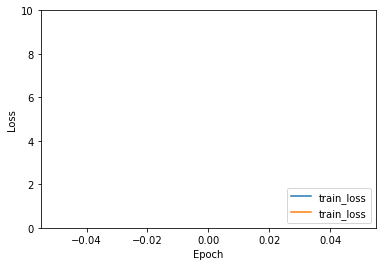

In [26]:
# plot results
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label = 'train_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 10])
plt.legend(loc='lower right')

In [26]:
PREDICTIONS = len(test_data)//BATCH_SIZE
y_test = []
counter = 0
for i in tqdm(test_ds):
    if counter < PREDICTIONS:
        counter += 1
        for j in i[1]:
            y_test.append(np.where(j == True)[0][0])
    else:
        break
print(len(y_test))

340it [01:13,  4.60it/s]

43520


In [27]:
y_pred = model.predict(test_ds, steps=PREDICTIONS)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = y_test
cmn = confusion_matrix(predicted_categories, true_categories, normalize="true")

df_cm = pd.DataFrame(cmn, index = [i for i in CLASS_NAMES],
                  columns = [i for i in CLASS_NAMES])